# Adaptive boosting for ensemble classification
---

__This page can be downloaded as__ [interactive jupyter notebook](./Boosting.ipynb).

---
In this notebook, we implement AdaBoost (Adaptive Boosting), a technique for jointly training many weak classifiers in order to create a strong classifier in the end by using them as an ensemble. While a strong classifier can represent complex models, a weak classifier is usually just slightly better than chance (being better than chance is a required prerequisite here). In this tutorial different decision trees are used as weak classifiers and afterwards combined to a strong one. 

First, the working process of Adaboost is shown step by step in order to see how the samples' weight and classifiers' weight change in the process of boosted training and how they are influenced by each other. After this, we will implement Adaboost by building a class which contains both training of weak classifiers and the predictive function using the ensemble.
## Theoretical principles

We start by a short repetition of the Adaboost steps:

### Step 1:

We train a weak classification model $h_i$ by minimizing the weighted training error 

$\ J = \sum_{n=1}^N w_n\cdot\delta(h_i(x_n), C_n)$

using ground truth labels $C_n$ and the sample weights $w_n$ for samples $x_n$. The sample weights are initialized as $ w_{n} = \dfrac{1}{N} $, where $N$ is the total number of samples.   Here $\delta$ indicates if a classification is correct or wrong:  

$\delta(h_i(x_n, C_n)=0 \hspace{2cm}if: \hspace{0.2cm}x_n = C_n$ 

and 

$\delta(h_i(x_n, C_n)=1 \hspace{2cm}if: \hspace{0.2cm} x_n \neq C_n$

### Step 2:

After we trained the classifier, we use the error rate 

$\epsilon=\frac{J_i}{\sum_{n=1}^N w_{n}}$

to compute the classifiers' weight 

$\alpha_i=ln(\frac{1-\epsilon}{\epsilon}) $

as well as the new weights 

$w_{n,i+1}=w_{n,i}\cdot\exp(\alpha_i\cdot\delta(h_i(x_n),C_n)$

Lastly, the weights such that they sum up to one: 

$w_n=\frac{w_n}{\sum_{n=1}^N w_n}$

Those two steps will be repeated $M$ times, resulting in $M$ weak classifiers. In the end, the ensemble $H$ can be used for classification by considering all weak classifiers predictions according to their weights. In the two class case $C_n \in (1,-1)$ this can be done according to

$H(x)= sign(\sum_{m=1}^M\alpha_m\cdot{h_m(x)})$

## Preparation

We start by importing the required modules. In particular we use the decision tree implementation from scikit-learn.

In [1]:
import numpy as np  
import math                                          # Used for numerical computations
import matplotlib.pyplot as plt                      # Plotting library 
from sklearn.tree import DecisionTreeClassifier      # Implementation of decision tree

In [2]:
plt.rcParams['figure.figsize'] = [6, 6]  # This is to set the size of the plots in the notebook

Next, we will create a toy dataset with samples with two distributions according to two classes.

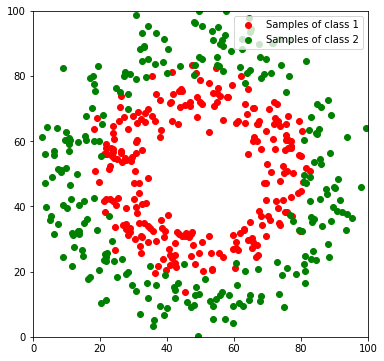

In [3]:
num_c = 2 # Number of clusters
colours = [[255, 170, 170], [170, 255, 170]] # RGB values: red and green 

# Generate the samples (2 clusters), we set a fixed seed make the results reproducable
np.random.seed(0) # without the seed reset every time(np.random.seed(0)), the same set of numbers will be drawn every time
c1_samples = np.random.randn(250, 2)
c2_samples = np.random.randn(250, 2) 
c1_samples /= np.sqrt(c1_samples[:,0:1:]**2 + c1_samples[:,1:2:]**2)
c2_samples /= np.sqrt(c2_samples[:,0:1:]**2 + c2_samples[:,1:2:]**2)
c1_samples = (c1_samples*25) + np.random.randn(250, 2)*5 + 50
c2_samples = (c2_samples*40) + np.random.randn(250, 2)*5 + 50
c1_samples = np.clip(c1_samples,0,100)
c2_samples = np.clip(c2_samples,0,100)


# Plot the samples, colored by class
plt.scatter(*zip(*c1_samples), c='red', marker='o', label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o', label='Samples of class 2')
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.legend(loc=1)
plt.show()

Next, we stack all data samples to one matrix and store the corresponding class labels.

In [4]:
all_samples = np.vstack((c1_samples, c2_samples))
C = np.hstack(((-1) * np.ones((250)),np.ones((250))))

## Training the first weak classifier
The very first step of Adaboost is to train the first weak classifier using the scikit-learn library and the initialized sample weights. 

In [5]:
h0 = DecisionTreeClassifier(criterion='entropy', max_depth = 3, max_features=2)
w0 = np.ones((500))/500

h0.fit(all_samples, C, w0)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

We can now use it to predict the classes and thus to compute the error rate

In [6]:
# prediction of class label will be used for computation of number of mis-classified samples
P0 = h0.predict(all_samples[:,:2])

# delta indicates which samples were misclassified
delta0 = (P0 != C).astype(np.int)

# Next is the error rate
err0 = np.sum(w0*delta0)/np.sum(w0)

We can also compute the accuracy to check if the weak classifier works better than chance. For a two class problem the accuracy should be higher than 50%. 

In [7]:
print('Accuracy:', 1-np.sum(delta0)/500)

Accuracy: 0.8240000000000001


In the next two cells, we implement functions to visualize the decision boundary (by predicting all features) and the probabilities.

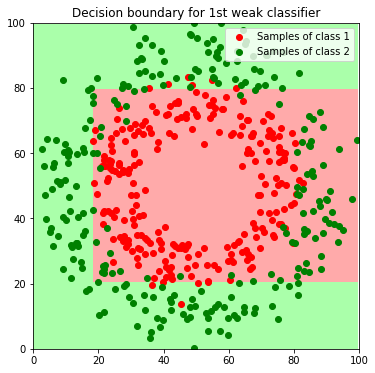

In [8]:
def predict_feature_space(model):
    label_map = np.zeros((100, 100, 3), dtype=np.ubyte) # creating a label map
    feature_space = []
    for x in range(100):
        for y in range(100):
            feature_space.append((x,y))
    feature_space = np.array(feature_space)
    labels = model.predict(feature_space) # creating a feature space
    for x in range(100):
        for y in range(100):
            label = labels[x*100+y]
            label_map[y, x] = colours[0] if label < 0 else colours[1]  
    return label_map

label_map = predict_feature_space(h0) # giving back the predicted labels here 

# below is the decision boundary predicted by first weak classifier
plt.imshow(label_map)
plt.scatter(*zip(*c1_samples), c='red', marker='o', label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o', label='Samples of class 2')
plt.title('Decision boundary for 1st weak classifier'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

After training the first weak classifier we need to calculate its' weight. The more accurate the classifier will be, the higher its' weight.

In [9]:
alpha0 = np.log((1-err0)/err0)

print('error rate of first weak classifier', err0)
print('weight of first weak classifier', alpha0)

error rate of first weak classifier 0.17599999999999996
weight of first weak classifier 1.5436865348713202


Before we continue with the next iteration we have to update the weights of the samples. By doing so, missclassified samples will get a higher weight.

In [10]:
w1 = w0 * np.exp(alpha0*delta0) 
w1 /= np.sum(w1)

Plotting the samples according to their weight together with the decision boundary shows, that only the weight of misclassified samples is increased.

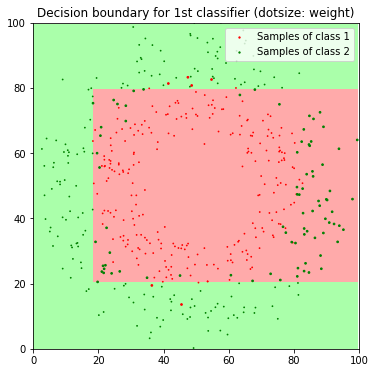

In [11]:
plt.imshow(predict_feature_space(h0))

plt.scatter(*zip(*c1_samples), c='red', marker='o',s=w1[:250]*500, label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o',s=w1[250:]*500,label='Samples of class 2')
plt.title('Decision boundary for 1st classifier (dotsize: weight)'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

## Training the second weak classifier

Next, we train another weak classifier using the updated weights.

In [12]:
h1 = DecisionTreeClassifier(criterion='entropy', max_depth = 3, max_features=2)
h1.fit(all_samples, C, w1)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

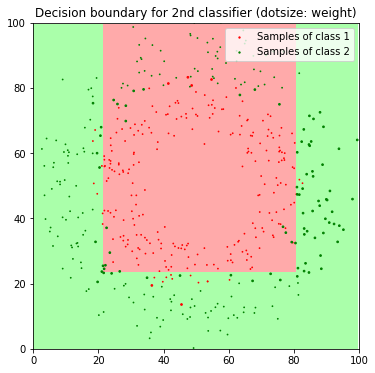

In [13]:
plt.imshow(predict_feature_space(h1))
plt.scatter(*zip(*c1_samples), c='red', marker='o',s=w1[:250]*500, label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o',s=w1[250:]*500, label='Samples of class 2')
plt.title('Decision boundary for 2nd classifier (dotsize: weight)'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

From above sample weights, we can notice that, mis-classified samples from first weak classifier got higher weights. Those correctly classified samples are assigned with lower weights. And, a smaller the error rate, the bigger the weight of classifier. Decision boundary predicted by second weak classifier which focuses on mis-classified samples, it is shown below. 

New parameters computation part, which is also getting ready for adding third weak classifier. 

In [14]:
P1 = h1.predict(all_samples[:,:2])
delta1 = (P1 != C).astype(np.int)
err1 = np.sum(w1*delta1)/np.sum(w1)

alpha1 = np.log((1-err1)/err1)
w2 = w1 * np.exp(alpha1*delta1) 
w2 /= np.sum(w2)

print('error rate of second weak classifier', err1)
print('weight of second weak classifier', alpha1)

error rate of second weak classifier 0.19571932921447482
weight of second weak classifier 1.413266662133179


From below, we can notice samples weights used by second weak classifier, those samples have higher weights are mis-classified samples from first weak classifier. It's not hard to see how mis-classified samples are affecting decision boundary. 

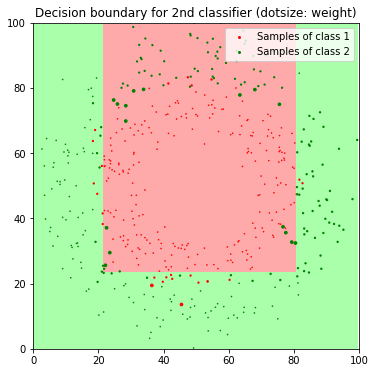

In [15]:
plt.imshow(predict_feature_space(h1))
plt.scatter(*zip(*c1_samples), c='red', marker='o',s=w2[:250]*500, label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o',s=w2[250:]*500, label='Samples of class 2')
plt.title('Decision boundary for 2nd classifier (dotsize: weight)'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

## Training the third weak classifier

Now, we are including third weak classifier. 

In [16]:
h2 = DecisionTreeClassifier(criterion='entropy', max_depth = 3, max_features=2)
h2.fit(all_samples[:,:2], C, w2)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
P2 = h2.predict(all_samples[:,:2])
delta2 = (P2 != C).astype(np.int)
err2 = np.sum(w2*delta2)/np.sum(w2)

alpha2 = np.log((1-err2)/err2)

print('error rate of third weak classifier', err2)
print('weight of third weak classifier', alpha2)

error rate of third weak classifier 0.1447068848463479
weight of third weak classifier 1.776734022280739


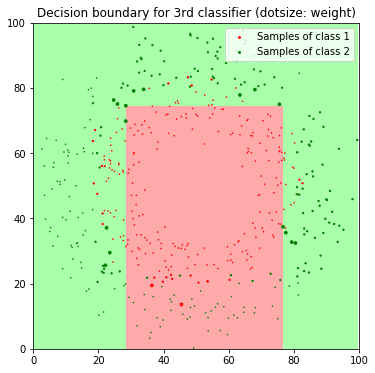

In [18]:
plt.imshow(predict_feature_space(h2))
plt.scatter(*zip(*c1_samples), c='red', marker='o',s=w2[:250]*500, label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o',s=w2[250:]*500, label='Samples of class 2')
plt.title('Decision boundary for 3rd classifier (dotsize: weight)'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

## Combining the weak classifiers

Next, we will combine the three weak classifiers in order to check, if we achieved an improvement.

In [19]:
P_ens = np.sign(alpha0*P0 + alpha1*P1 + alpha2*P2) # combination by weighted sum

print('Accuracy of h0:', 1-np.sum(delta0)/500)
print('Accuracy of h1:', 1-np.sum(delta1)/500)
print('Accuracy of h2:', 1-np.sum(delta2)/500)
print('Ensamble accuracy:', np.sum(C==P_ens)/500)

Accuracy of h0: 0.8240000000000001
Accuracy of h1: 0.81
Accuracy of h2: 0.746
Ensamble accuracy: 0.926


We clearly achieved an improvement by using a few weak classifiers as ensemble!

## AdaBoost

Next, we will implement AdaBoost based on decision trees in a single class. This makes it easier to vary the number of models. We follow the class structure from the scikit-learn library.

In [20]:
class Adaboost():
    def __init__(self, num_classifiers):
        self.num_classifiers = num_classifiers # number of weak classifiers 
        
    def fit(self, X, y, w): 
        # X: data samples
        # y: corresponding class labels
        # w: initial weights of samples
     
        self.weak_classifiers = []    # generated weak classifiers will be stored here 
        self.classifiers_weights = [] # computed weak classifiers' weights will be stored here 
        
        for i in range(self.num_classifiers):
             # generate weak classifier and train it
            h = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=2)
            h.fit(X, y, w)
            self.weak_classifiers.append(h)
            
            delta = (h.predict(X) != y).astype(np.int)
            err = np.sum(w*delta)/np.sum(w)

            alpha = np.log((1-err)/err)
            self.classifiers_weights.append(alpha) 
            
            w = w * np.exp(alpha*delta) # update weights
            w /= np.sum(w)              # normalize weights
            
    def predict(self, X):
        # X: test samples
        
        sum_predictions = np.zeros((X.shape[0]))
        for i in range(self.num_classifiers): # all weak classifiers are combined here
           
            h = self.weak_classifiers[i] 
            weight = self.classifiers_weights[i]

            # the classifier contributes according to its'weight
            sum_predictions += h.predict(X) *weight

        return np.sign(sum_predictions)
        

Now that we have modeled the AdaBoost method, we will train an ensemble with 5 weak classifiers.

In [22]:
ada = Adaboost(num_classifiers = 5) 
w0 = np.ones((500))/500
ada.fit(all_samples, C, w0)

print('Accuracy:', np.sum(ada.predict(all_samples)==C)/500) # Ensambles'training accuracy

Accuracy: 0.938


We visualize the decision boundary of the strong classifier.

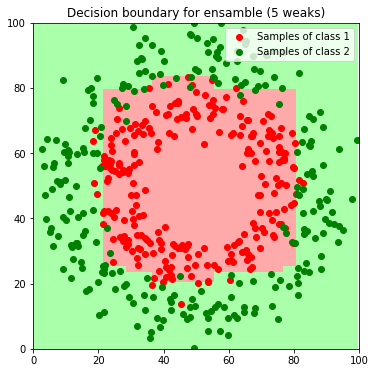

In [23]:
label_map = predict_feature_space(ada)  
plt.imshow(label_map)
plt.scatter(*zip(*c1_samples), c='red', marker='o', label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o', label='Samples of class 2')
plt.title('Decision boundary for ensamble (5 weaks)'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

This represents the true distributions already quite well! In the next cell we will further increase the number of weak classifiers until we decrease the training error to zero. 

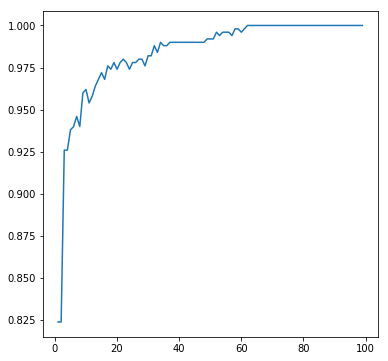

In [24]:
num_weaks = list(range(1,100))
accuracies = []

for i in num_weaks:
    adab = Adaboost(num_classifiers = i) 

    w0 = np.ones((500))/500
    adab.fit(all_samples, C, w0)

    accuracies.append(np.sum(adab.predict(all_samples)==C)/500)
    
plt.plot(num_weaks,accuracies)
plt.show()

We see, that the improvement is very high, when we increase the number of weak classifiers from 2 to 3. Afterwards the accuracy increases slower. We need about 70 weak classifiers to reduce the training error to zero. 

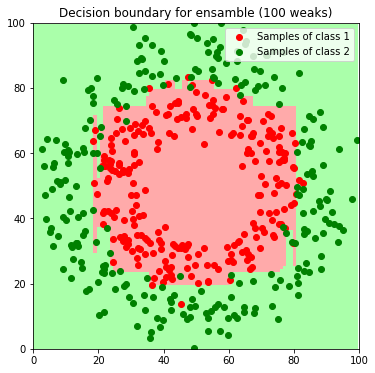

In [25]:
label_map = predict_feature_space(adab)  
plt.imshow(label_map)
plt.scatter(*zip(*c1_samples), c='red', marker='o', label='Samples of class 1')
plt.scatter(*zip(*c2_samples), c='green', marker='o', label='Samples of class 2')
plt.title('Decision boundary for ensamble (100 weaks)'); plt.legend(loc=1)
plt.xlim((0, 100)); plt.ylim((0, 100)); plt.show()

We have to keep in mind, that having a training accuracy of 100% not necessarily implies a good model. Often this means we already overfitted to the training data which has to be validated using a test dataset.

Following code-cell removes `In[]` / `Out[]` prompts left to code cells.

In [27]:
%%HTML
<style>div.prompt {display:none}</style>

---

<table>
  <tr>
    <td>Author:</td>
    <td>Buerlike Alai</td>
  </tr>
  <tr>
    <td>Last modified:</td>
    <td>01 / 07 / 2019</td>
  </tr>
</table> 